In [2]:
from typing import Annotated, Literal, List, Dict, Any, Union
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import base64
from IPython.display import display, HTML

# LangChain imports
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.prebuilt import create_react_agent
from langgraph.graph import StateGraph, START, END, MessagesState
from langgraph.types import Command

# Create a random dataset that we'll use for analysis
def create_random_dataset(rows=100):
    """Create a random sales dataset for demonstration purposes."""
    np.random.seed(42)
    
    # Create date range for the past 2 years
    dates = pd.date_range(end=pd.Timestamp.now(), periods=rows, freq='W')
    
    # Create product categories and regions
    categories = ['Electronics', 'Clothing', 'Home Goods', 'Sports', 'Books']
    regions = ['North', 'South', 'East', 'West', 'Central']
    
    # Generate random data
    data = {
        'Date': dates,
        'Product': np.random.choice(categories, size=rows),
        'Region': np.random.choice(regions, size=rows),
        'Sales': np.random.randint(1000, 10000, size=rows),
        'Units': np.random.randint(10, 100, size=rows),
        'Customer_Age': np.random.randint(18, 65, size=rows),
        'Rating': np.round(np.random.uniform(1, 5, size=rows), 1),
        'Discount': np.round(np.random.uniform(0, 0.3, size=rows), 2)
    }
    
    # Create DataFrame
    df = pd.DataFrame(data)
    
    # Add some calculated columns
    df['Revenue'] = df['Sales'] - (df['Sales'] * df['Discount'])
    df['Month'] = df['Date'].dt.month_name()
    df['Quarter'] = 'Q' + df['Date'].dt.quarter.astype(str)
    df['Year'] = df['Date'].dt.year
    
    return df

# Create the dataset
sales_df = create_random_dataset(150)
print(sales_df)

                          Date     Product   Region  Sales  Units  \
0   2022-05-08 16:33:52.254806      Sports    North   2060     44   
1   2022-05-15 16:33:52.254806       Books    North   3327     96   
2   2022-05-22 16:33:52.254806  Home Goods    North   4420     90   
3   2022-05-29 16:33:52.254806       Books    North   1301     99   
4   2022-06-05 16:33:52.254806       Books     East   1606     17   
..                         ...         ...      ...    ...    ...   
145 2025-02-16 16:33:52.254806      Sports  Central   5380     66   
146 2025-02-23 16:33:52.254806      Sports  Central   5107     27   
147 2025-03-02 16:33:52.254806  Home Goods     East   6726     56   
148 2025-03-09 16:33:52.254806    Clothing     West   4373     58   
149 2025-03-16 16:33:52.254806      Sports    North   9945     23   

     Customer_Age  Rating  Discount  Revenue     Month Quarter  Year  
0              32     1.5      0.13  1792.20       May      Q2  2022  
1              48     1.6    

In [ ]:
OPENAI_API_KEY = 'MY_OPENAI_KEY'

In [4]:
# Function to display dataframe info
def get_dataframe_info():
    """Get information about the dataframe structure"""
    buffer = io.StringIO()
    sales_df.info(buf=buffer)
    info_str = buffer.getvalue()
    
    # Get basic statistics
    stats = sales_df.describe().to_string()
    
    # Get sample rows
    sample = sales_df.head(5).to_string()
    
    return f"""
DataFrame Information:
{info_str}

Basic Statistics:
{stats}

Sample Rows:
{sample}
"""

In [29]:
# Create global variables to store intermediate results
filtered_data = None
analysis_data = None
# Define tools for each agent
@tool
def filter_data_function(
    query: Annotated[str, "The filtering criteria to apply to the dataset"]
) -> str:
    """
    Filter the sales dataset based on the provided query.
    The query should be a valid Python expression that can be evaluated in the context of a pandas DataFrame.
    Examples: "df[df['Region'] == 'North']", "df[(df['Sales'] > 5000) & (df['Product'] == 'Electronics')]"
    """
    global filtered_data
    
    try:
        # Create a local copy of the dataframe to evaluate the expression
        df = sales_df.copy()
        
        # Evaluate the query
        filtered_df = eval(query)
        
        if isinstance(filtered_df, pd.DataFrame):
            if filtered_df.empty:
                return "The filter returned no results. Please try a different filter."
            
            result = f"Filtered data successfully. {len(filtered_df)} rows returned.\n"
            result += f"Sample of filtered data (first 5 rows):\n{filtered_df.head(5).to_string()}"
            
            # Store the filtered dataframe for later use
            filtered_data = filtered_df
            
            return result
        else:
            return "Error: The filter did not return a DataFrame. Make sure your filter returns a DataFrame."
    except Exception as e:
        return f"Error in filtering data: {str(e)}"

@tool
def analyze_data_function(
    analysis_code: Annotated[str, "The Python code to analyze the filtered data"]
) -> str:
    """
    Run analysis on the filtered dataset. The analysis_code should be valid Python code.
    The filtered data is available as the variable 'df'.
    Example: "df.groupby('Product')['Sales'].sum()"
    """
    global analysis_data
    
    try:
        if filtered_data is None:
            return "No filtered data available. Please run filter_data first."
        
        # Create a local copy with a simple name
        df = filtered_data.copy()
        
        # Execute the analysis code
        result = eval(analysis_code)
        
        # Convert various result types to string representation
        if isinstance(result, pd.DataFrame):
            analysis_result = f"Analysis results:\n{result.to_string()}"
            
            # Store for visualization
            analysis_data = result
            
            return analysis_result
        elif isinstance(result, pd.Series):
            analysis_result = f"Analysis results:\n{result.to_string()}"
            
            # Store for visualization
            analysis_data = result
            
            return analysis_result
        else:
            return f"Analysis results:\n{result}"
    except Exception as e:
        return f"Error in analyzing data: {str(e)}"

@tool
def visualize_data_function(
    viz_code: Annotated[str, "The Python code using matplotlib to visualize the analyzed data"]
) -> str:
    """
    Create visualizations based on the analyzed data using matplotlib.
    The analyzed data is available as 'df' for filtered data or 'analysis_data' for analysis results.
    The code should create a matplotlib figure and save it.
    """
    print("executing visualize_data_function")
    try:
        plt.close('all')
        
        # Check if we have data to visualize
        if filtered_data is None:
            return "No filtered data available. Please run filter_data first."
        
        # Make data available as df
        df = filtered_data.copy()
        
        # Make analysis data available if it exists
        if analysis_data is not None:
            analysis_df = analysis_data
        
        # Create a figure
        plt.figure(figsize=(10, 6))
        
        # Execute the visualization code
        exec(viz_code)
        
        # Save the figure to a bytes buffer
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        
        # Encode to base64 for display
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        
        # Close the figure to free memory
        plt.close()
        print("visualize_data_function finished")
        # For Jupyter notebook, we can display the image
        # if 'get_ipython' in globals():
        #     display(HTML(f'<img src="data:image/png;base64,{img_str}"/>'))
        # print("visualize_data_function finished")
        return f"FINAL ANSWER. Visualization created successfully.\n<img src='data:image/png;base64,{img_str}'/>"
    except Exception as e:
        return f"Error in creating visualization: {str(e)}"

# Initialize the OpenAI LLM
llm = ChatOpenAI(model="gpt-4o", api_key=OPENAI_API_KEY)

# Create system prompts for each agent
def make_system_prompt(role_description):
    dataset_info = get_dataframe_info()
    return f"""You are an AI assistant that is part of a multi-agent system for data analysis and visualization.

{role_description}

You have access to a sales dataset with the following structure:

{dataset_info}

Follow these guidelines:
1. Think step by step about the user's question
2. Determine what actions you need to take based on your specific role
3. Use your available tools to complete your part of the task
4. When you've completed your responsibility, hand off to the appropriate next agent
5. Only respond with FINAL ANSWER when the entire workflow is complete and a visualization has been created

Collaborate with the other agents to complete the full task pipeline: 
data_filtering → data_analysis → data_visualization
"""

# Create the agents
data_filtering_agent = create_react_agent(
    llm,
    tools=[filter_data_function],
    prompt=make_system_prompt("Your role is DATA FILTERING. You can only filter the dataset based on user queries. You work with data analysis and visualization colleagues.")
)

data_analysis_agent = create_react_agent(
    llm,
    tools=[analyze_data_function],
    prompt=make_system_prompt("Your role is DATA ANALYSIS. You can only analyze the filtered dataset. You work with data filtering and visualization colleagues.")
)

data_vis_agent = create_react_agent(
    llm,
    tools=[visualize_data_function],
    prompt=make_system_prompt("Your role is DATA VISUALIZATION. You can only create visualizations using matplotlib based on the filtered and analyzed data. You work with data filtering and analysis colleagues.")
)

# Define the graph nodes
def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        return END
    return goto

def data_filtering_node(state: MessagesState) -> Command[Literal["data_analysis", END]]:
    result = data_filtering_agent.invoke(state)
    print("data_filtering_node result")
    print(result)
    goto = get_next_node(result["messages"][-1], "data_analysis")
    
    # Wrap in a human message with agent name
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="data_filtering_agent"
    )
    
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

def data_analysis_node(state: MessagesState) -> Command[Literal["data_vis", END]]:
    result = data_analysis_agent.invoke(state)
    print("data_analysis_node result")
    print(result)
    goto = get_next_node(result["messages"][-1], "data_vis")
    
    # Wrap in a human message with agent name
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="data_analysis_agent"
    )
    
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

def data_vis_node(state: MessagesState) -> Command[Literal[END]]:
    result = data_vis_agent.invoke(state)
    print("data_vis_node result")
    print(result)
    goto = END  # Visualization is the last step
    
    # Wrap in a human message with agent name
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="data_vis_agent"
    )
    
    return Command(
        update={"messages": result["messages"]},
        goto=goto,
    )

# Create the graph
workflow = StateGraph(MessagesState)
workflow.add_node("data_filtering", data_filtering_node)
workflow.add_node("data_analysis", data_analysis_node)
workflow.add_node("data_vis", data_vis_node)

# Add edges
workflow.add_edge(START, "data_filtering")
workflow.add_edge("data_filtering", "data_analysis")
workflow.add_edge("data_analysis", "data_vis")

# Compile the graph
graph = workflow.compile()

import re
def process_query(user_query: str):
    """Process a user query through the multi-agent workflow"""
    messages = [HumanMessage(content=user_query)]

    print(messages)
    result = graph.invoke({"messages": messages})
    
    # Extract the final messages
    final_messages = result["messages"]

    # **DEBUG: 检查 function.name 是否符合规范**
    for i, message in enumerate(final_messages):
        if isinstance(message, AIMessage) and hasattr(message, "tool_calls"):
            for j, tool_call in enumerate(message.tool_calls):
                # print(j,"toolcall:", tool_call)
                if "name" in tool_call:  # 确保 `name` 字段存在
                    function_name = tool_call["name"]
                    if not re.match(r"^[a-zA-Z0-9_-]+$", function_name):
                        print(f"\n⚠️ Invalid function name at messages[{i}].tool_calls[{j}]: {function_name}")


    # **DEBUG: 打印整个对话过程**
    for message in final_messages:
        if hasattr(message, 'name') and message.name:
            print(f"\n[{message.name}]: {message.content}\n")
        elif isinstance(message, HumanMessage):
            print(f"\n[User]: {message.content}\n")
        elif isinstance(message, AIMessage):
            print(f"\n[AI]: {message.content}\n")
        else:
            print(f"\n[Unknown]: {message.content}\n")

    # Find and extract the last message with visualization
    for message in reversed(final_messages):
        if isinstance(message, HumanMessage) and "data_vis_agent" == message.name and "FINAL ANSWER" in message.content:
            return message.content, result
    
    return "No visualization was generated.", result



[HumanMessage(content='How have total sales changed over time? Can we visualize the sales trend using a time series plot?', additional_kwargs={}, response_metadata={})]
data_filtering_node result
{'messages': [HumanMessage(content='How have total sales changed over time? Can we visualize the sales trend using a time series plot?', additional_kwargs={}, response_metadata={}, id='0284a917-c6c6-4b27-9c68-3ce2f261756b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KieVrRukVGftr3mmGcVQttKv', 'function': {'arguments': '{"query":"df[[\'Date\', \'Sales\']].sort_values(by=\'Date\')"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 1365, 'total_tokens': 1394, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_

<Figure size 1000x600 with 0 Axes>

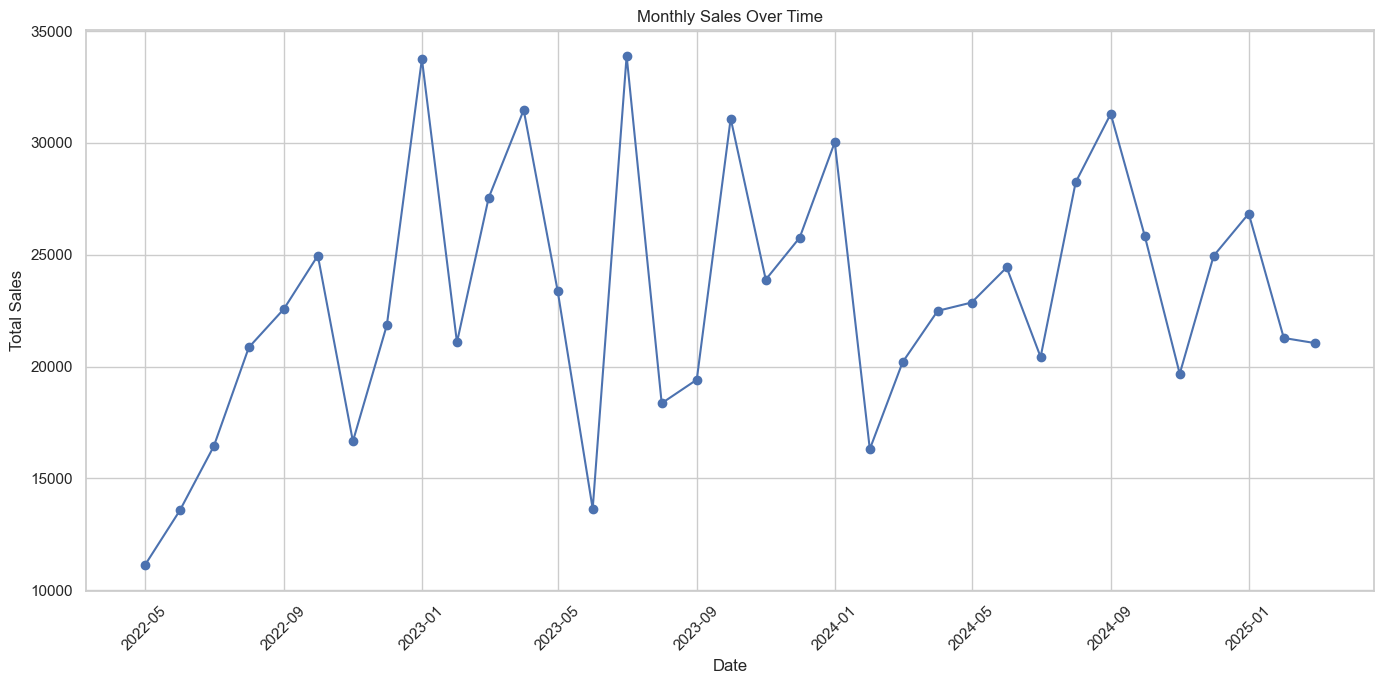

visualize_data_function finished
data_vis_node result
{'messages': [HumanMessage(content='How have total sales changed over time? Can we visualize the sales trend using a time series plot?', additional_kwargs={}, response_metadata={}, id='0284a917-c6c6-4b27-9c68-3ce2f261756b'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KieVrRukVGftr3mmGcVQttKv', 'function': {'arguments': '{"query":"df[[\'Date\', \'Sales\']].sort_values(by=\'Date\')"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 29, 'prompt_tokens': 1365, 'total_tokens': 1394, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6ec83003ad', 'id': 'chatcmpl-BE6QMfryraPl6DeImbbjXkJ687sC8', 'finish_reason': 'tool_call
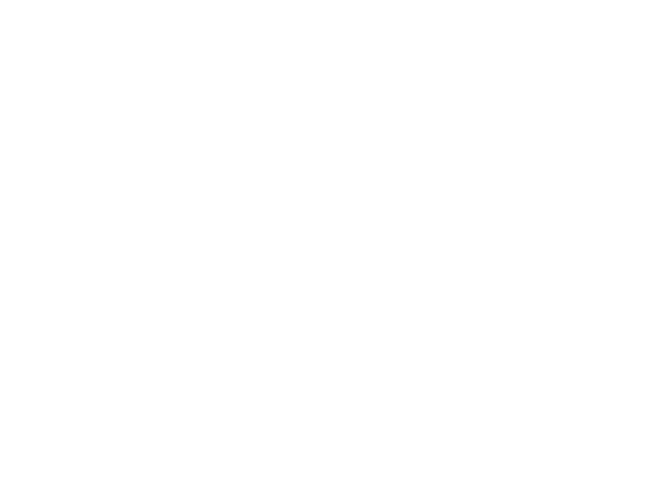
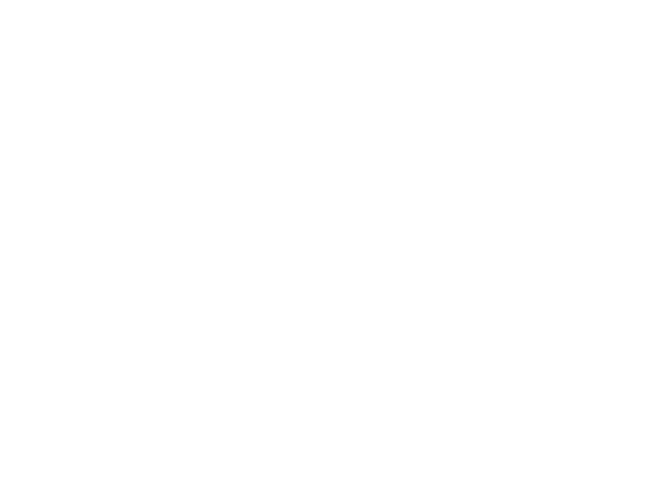
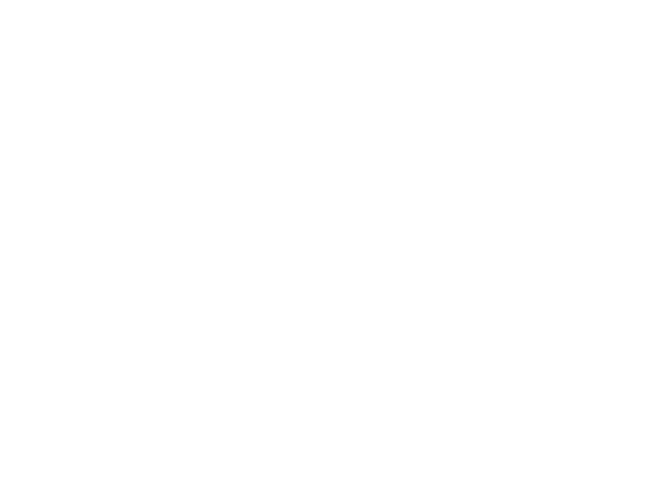

In [32]:
# Example usage
# Example query
query = "How have total sales changed over time? Can we visualize the sales trend using a time series plot?"
result, messages = process_query(query)


print("Query processing complete!")
print(messages)

Here are some possible data visualization questions based on the given dataset:  

1. **Sales Trend Over Time**:  
   - How have total sales changed over time? Can we visualize the sales trend using a time series plot?  

2. **Revenue Distribution by Product Category**:  
   - What is the distribution of revenue across different product categories? Can we use a bar chart or boxplot to compare them?  

3. **Regional Sales Performance**:  
   - How do sales vary by region? Can we visualize this with a grouped bar chart or a heatmap?  

4. **Customer Age vs. Sales Impact**:  
   - Is there a relationship between customer age and total sales? Can we visualize this using a scatter plot or a box plot?  

5. **Effect of Discounts on Revenue**:  
   - How does the discount percentage affect revenue? Can we visualize this with a scatter plot or a regression line?  

6. **Product Sales Comparison Across Quarters**:  
   - How do sales of different product categories fluctuate across different quarters? Can we use a stacked bar chart or a line plot to observe the trend?  

7. **Sales Performance by Customer Rating**:  
   - How does the customer rating affect total sales? Can we use a scatter plot to analyze the correlation?  

8. **Monthly Sales Comparison**:  
   - Which month has the highest and lowest sales? Can we visualize this with a line plot or a bar chart?  

9. **Units Sold vs. Revenue Relationship**:  
   - How do the number of units sold relate to revenue? Can we use a scatter plot to visualize the correlation?  

10. **Top Performing Products**:  
   - Which products generate the highest revenue? Can we use a ranked bar chart to highlight the top-performing products?  

[HumanMessage(content='What is the distribution of revenue across different product categories? Can we use a bar chart or boxplot to compare them?', additional_kwargs={}, response_metadata={})]
data_filtering_node result
{'messages': [HumanMessage(content='What is the distribution of revenue across different product categories? Can we use a bar chart or boxplot to compare them?', additional_kwargs={}, response_metadata={}, id='354a1f02-774e-44c5-b7ba-65422d4ff7f7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KhlTkvqqpCdoAmsMbjYYz1NR', 'function': {'arguments': '{"query":"df.groupby(\'Product\')[\'Revenue\'].sum()"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1369, 'total_tokens': 1393, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio

<Figure size 1000x600 with 0 Axes>

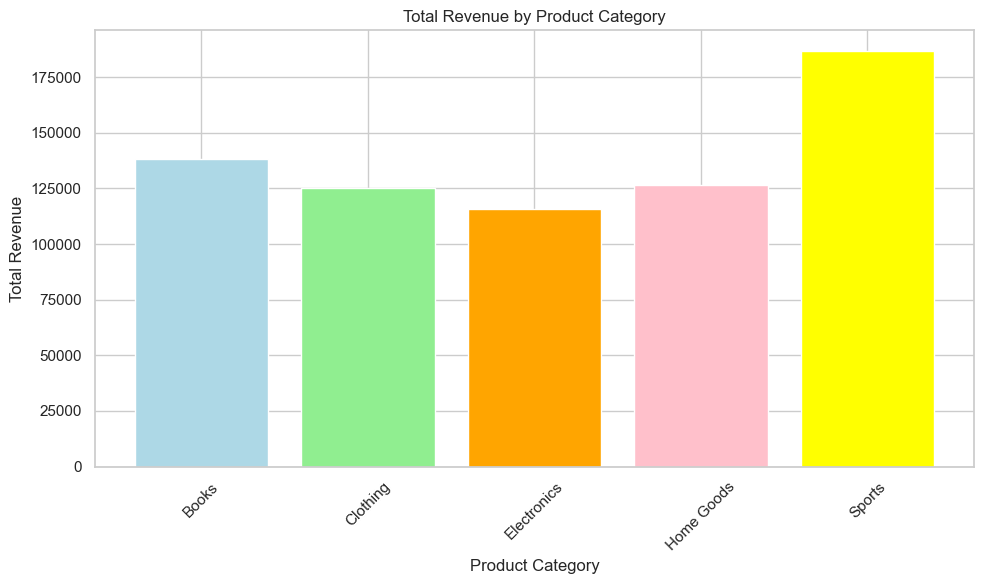

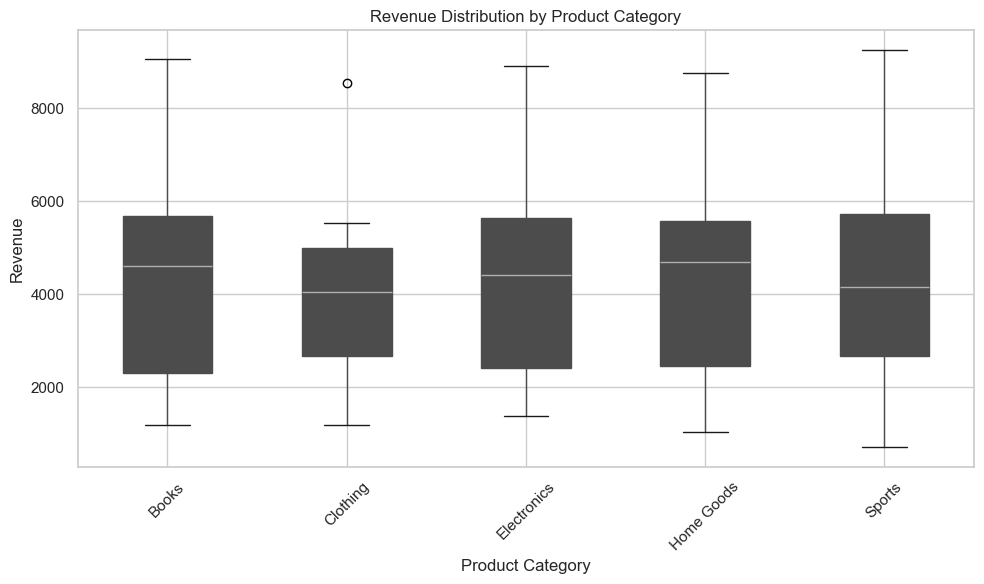

visualize_data_function finished
data_vis_node result
{'messages': [HumanMessage(content='What is the distribution of revenue across different product categories? Can we use a bar chart or boxplot to compare them?', additional_kwargs={}, response_metadata={}, id='354a1f02-774e-44c5-b7ba-65422d4ff7f7'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_KhlTkvqqpCdoAmsMbjYYz1NR', 'function': {'arguments': '{"query":"df.groupby(\'Product\')[\'Revenue\'].sum()"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1369, 'total_tokens': 1393, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6ec83003ad', 'id': 'chatcmpl-BE1plCgEGh83wf0EJxRAkDRYvp827', 'finish_re
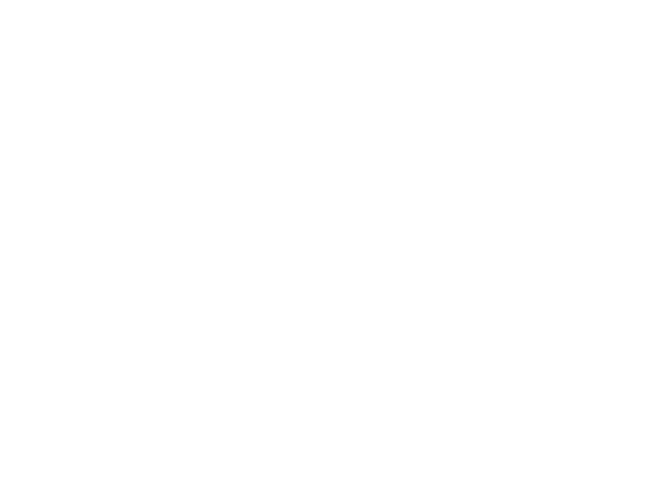
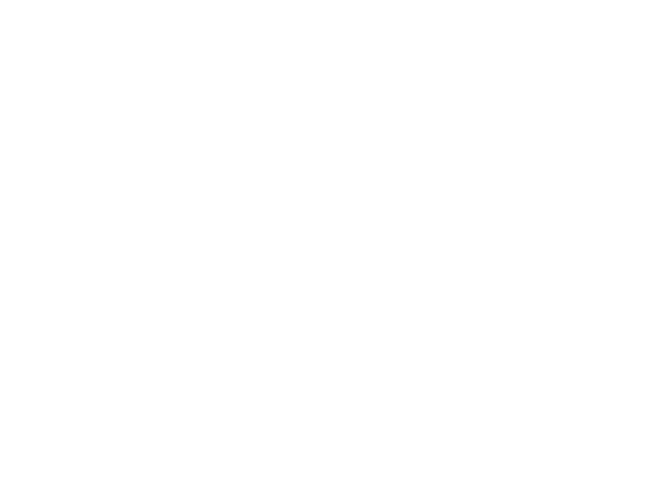

In [30]:
query = "What is the distribution of revenue across different product categories? Can we use a bar chart or boxplot to compare them?"
result, messages = process_query(query)

[HumanMessage(content='How does the discount percentage affect revenue? Can we visualize this with a scatter plot or a regression line?  ', additional_kwargs={}, response_metadata={})]
data_filtering_node result
{'messages': [HumanMessage(content='How does the discount percentage affect revenue? Can we visualize this with a scatter plot or a regression line?  ', additional_kwargs={}, response_metadata={}, id='3f56e45a-bd09-4280-aa84-d9ae91869ed0'), AIMessage(content='To analyze how the discount percentage affects revenue, I will first filter the dataset to include only the necessary columns for this analysis, which are "Discount" and "Revenue". Then, I\'ll pass it on to the data analysis agent to further process and create the visualization. \n\nLet\'s start by filtering the data.', additional_kwargs={'tool_calls': [{'id': 'call_h2q2ayFHS2Ls5zJH48iIIZ6V', 'function': {'arguments': '{"query":"df[[\'Discount\', \'Revenue\']]"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'ref

<Figure size 1000x600 with 0 Axes>

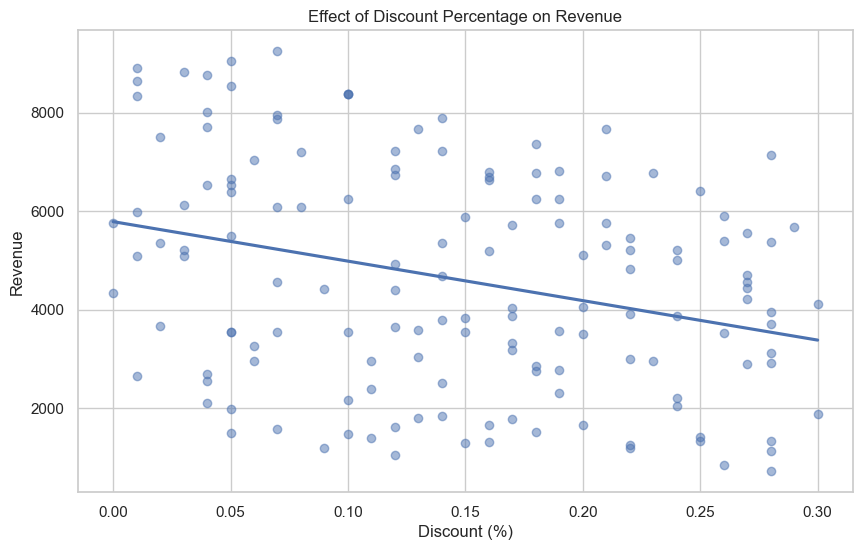

visualize_data_function finished
data_vis_node result
{'messages': [HumanMessage(content='How does the discount percentage affect revenue? Can we visualize this with a scatter plot or a regression line?  ', additional_kwargs={}, response_metadata={}, id='3f56e45a-bd09-4280-aa84-d9ae91869ed0'), AIMessage(content='To analyze how the discount percentage affects revenue, I will first filter the dataset to include only the necessary columns for this analysis, which are "Discount" and "Revenue". Then, I\'ll pass it on to the data analysis agent to further process and create the visualization. \n\nLet\'s start by filtering the data.', additional_kwargs={'tool_calls': [{'id': 'call_h2q2ayFHS2Ls5zJH48iIIZ6V', 'function': {'arguments': '{"query":"df[[\'Discount\', \'Revenue\']]"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 85, 'prompt_tokens': 1367, 'total_tokens': 1452, 'completion_tokens_details': {'accepted
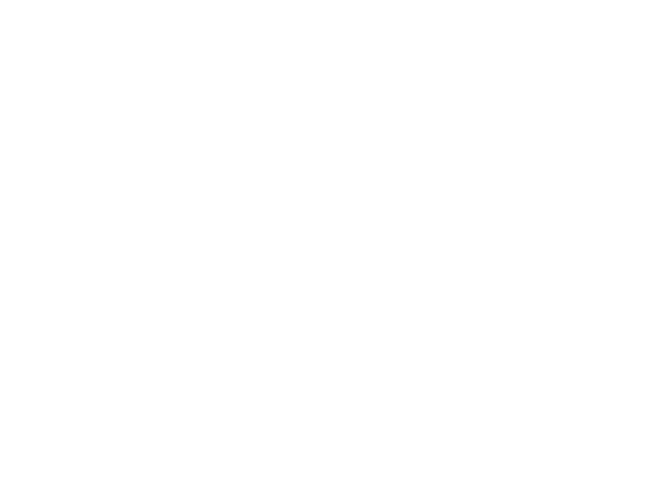
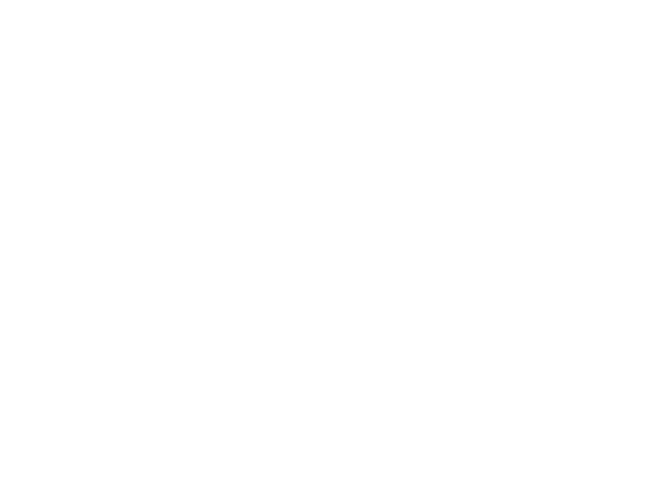

In [33]:
query = "How does the discount percentage affect revenue? Can we visualize this with a scatter plot or a regression line?  "
result, messages = process_query(query)

[HumanMessage(content=' How does the customer rating affect total sales? Can we use a scatter plot to analyze the correlation?    ', additional_kwargs={}, response_metadata={})]
data_filtering_node result
{'messages': [HumanMessage(content=' How does the customer rating affect total sales? Can we use a scatter plot to analyze the correlation?    ', additional_kwargs={}, response_metadata={}, id='7916c3a3-59ae-441a-a9c2-7debdcf22fd5'), AIMessage(content="To analyze how customer rating affects total sales, we will filter the relevant columns from the dataset. In this case, we need the 'Rating' and 'Sales' columns.\n\nLet's filter the dataset to include these columns, and then hand it over to the data analysis and visualization agents.", additional_kwargs={'tool_calls': [{'id': 'call_zApkBpBujQJnYc3kjQYRS2FE', 'function': {'arguments': '{"query":"df[[\'Rating\', \'Sales\']]"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'com

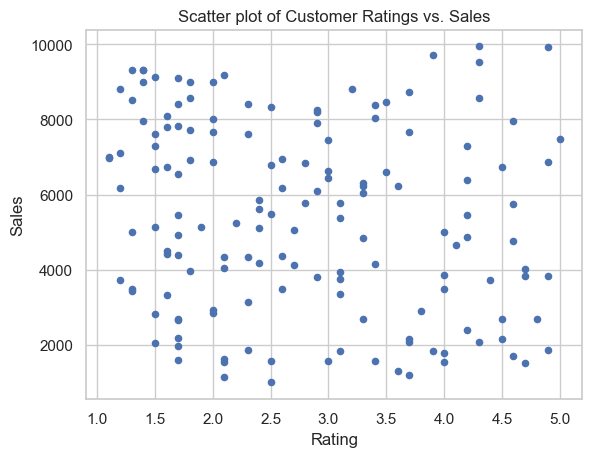

In [34]:
query = " How does the customer rating affect total sales? Can we use a scatter plot to analyze the correlation?    "
result, messages = process_query(query)

[HumanMessage(content='Which products generate the highest revenue? Can we use a ranked bar chart to highlight the top-performing products?  ', additional_kwargs={}, response_metadata={})]
data_filtering_node result
{'messages': [HumanMessage(content='Which products generate the highest revenue? Can we use a ranked bar chart to highlight the top-performing products?  ', additional_kwargs={}, response_metadata={}, id='ee42ed4f-268a-4dac-bda2-1c12c82d7625'), AIMessage(content="To determine which products generate the highest revenue, we need to follow these steps:\n\n1. Filter the dataset to aggregate revenue data by product.\n2. Analyze the aggregated data to identify the top-performing products by revenue.\n3. Visualize the results using a ranked bar chart.\n\nI'll start by filtering and aggregating the dataset to get the total revenue generated by each product.", additional_kwargs={'tool_calls': [{'id': 'call_CwOuYgNNyCwGENQUmv7Ixwd8', 'function': {'arguments': '{"query":"df.groupby(\

<Figure size 1000x600 with 0 Axes>

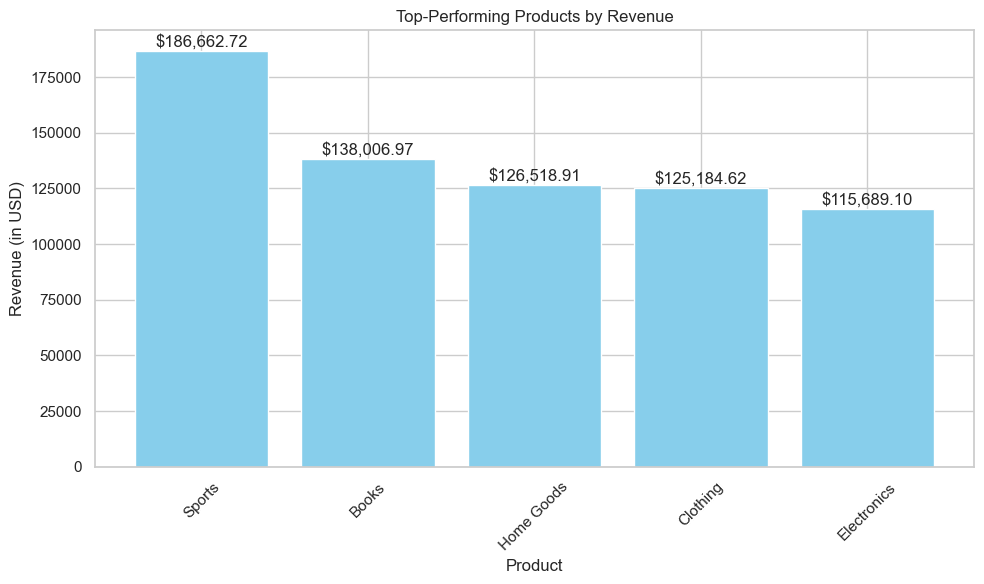

visualize_data_function finished
data_vis_node result
{'messages': [HumanMessage(content='Which products generate the highest revenue? Can we use a ranked bar chart to highlight the top-performing products?  ', additional_kwargs={}, response_metadata={}, id='ee42ed4f-268a-4dac-bda2-1c12c82d7625'), AIMessage(content="To determine which products generate the highest revenue, we need to follow these steps:\n\n1. Filter the dataset to aggregate revenue data by product.\n2. Analyze the aggregated data to identify the top-performing products by revenue.\n3. Visualize the results using a ranked bar chart.\n\nI'll start by filtering and aggregating the dataset to get the total revenue generated by each product.", additional_kwargs={'tool_calls': [{'id': 'call_CwOuYgNNyCwGENQUmv7Ixwd8', 'function': {'arguments': '{"query":"df.groupby(\'Product\')[\'Revenue\'].sum().reset_index()"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'comp
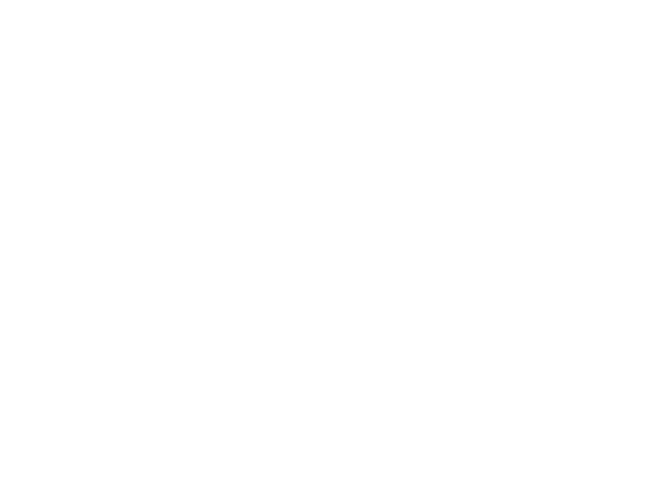
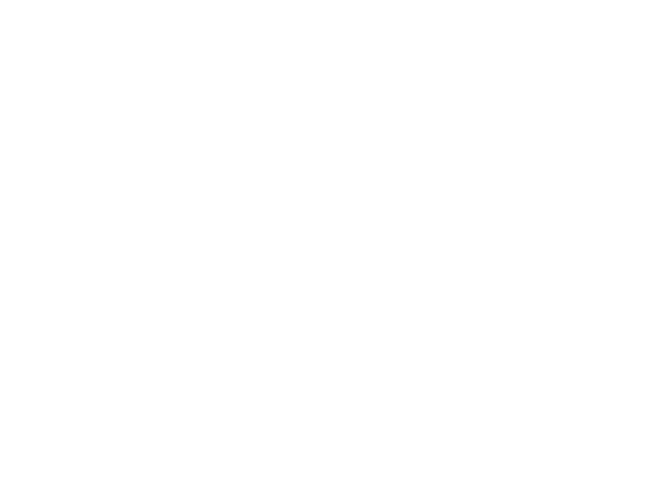

In [35]:
query = "Which products generate the highest revenue? Can we use a ranked bar chart to highlight the top-performing products?  "
result, messages = process_query(query)

[HumanMessage(content='Which month has the highest and lowest sales? Can we visualize this with a line plot or a bar chart?  ', additional_kwargs={}, response_metadata={})]
data_filtering_node result
{'messages': [HumanMessage(content='Which month has the highest and lowest sales? Can we visualize this with a line plot or a bar chart?  ', additional_kwargs={}, response_metadata={}, id='f01d7d5d-7085-4483-8f71-2b5a36a38602'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GFMQRp4RQLWALH44NaSGbHQf', 'function': {'arguments': '{"query":"df.groupby(\'Month\').sum().sort_values(\'Sales\', ascending=False)"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 1368, 'total_tokens': 1398, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cac

<Figure size 1000x600 with 0 Axes>

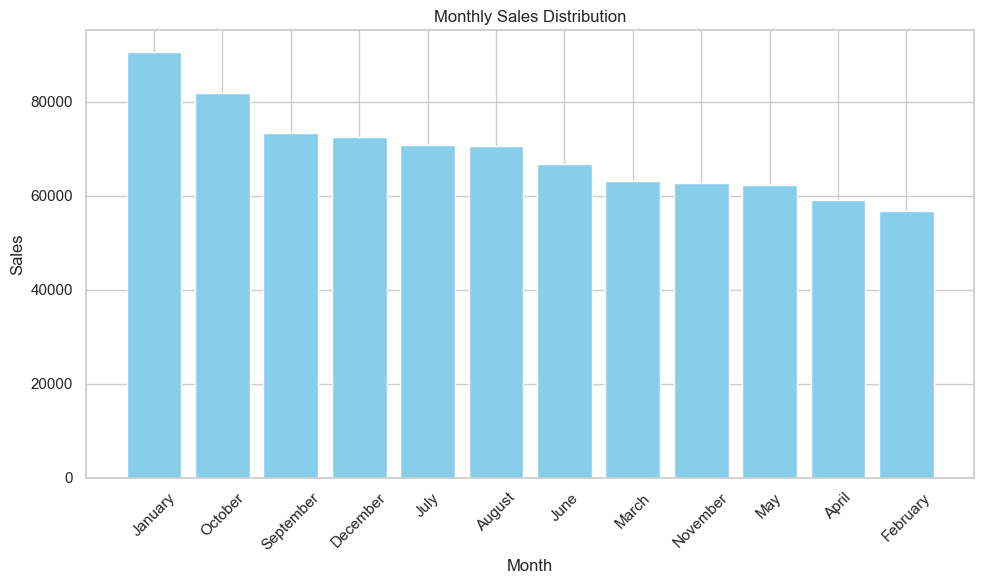

visualize_data_function finished
data_vis_node result
{'messages': [HumanMessage(content='Which month has the highest and lowest sales? Can we visualize this with a line plot or a bar chart?  ', additional_kwargs={}, response_metadata={}, id='f01d7d5d-7085-4483-8f71-2b5a36a38602'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_GFMQRp4RQLWALH44NaSGbHQf', 'function': {'arguments': '{"query":"df.groupby(\'Month\').sum().sort_values(\'Sales\', ascending=False)"}', 'name': 'filter_data_function'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 1368, 'total_tokens': 1398, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 1280}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_6ec83003ad', 'id': 'chatcmpl-BE6U3EHO6qRdoSnPFtjY796eaoaeD', 'fi
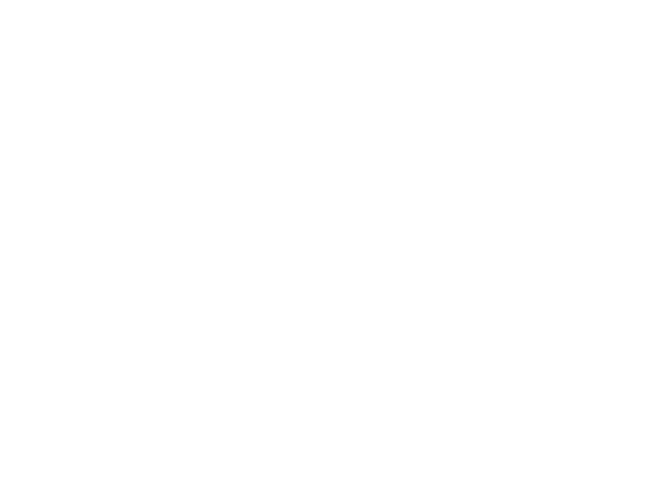
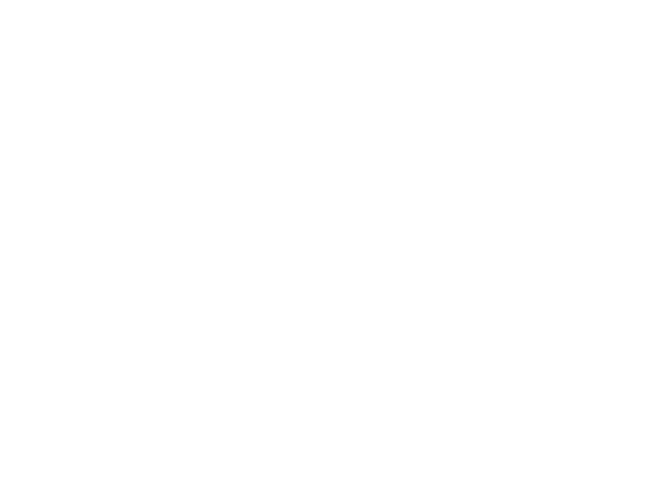

In [36]:
query = "Which month has the highest and lowest sales? Can we visualize this with a line plot or a bar chart?  "
result, messages = process_query(query)